**Modélisation du slicing dans les réseaux 5G**
-

**Bárbara Barsi Duarte Batista da Silva**

**Rafaela de Carvalho Machado Pinheiro**


--- 

**_Importation des bibliothèques_**

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

---

## Introduction
La 5G permet de déployer des réseaux virtuels de bout en bout, avec des profils de qualité de service (QoS) spécifiques, au-dessus d'une infrastructure physique commune. Le slicing est le terme utilisé pour désigner la fonctionnalité qui rend cette coexistence possible. Chaque réseau virtuel déployé est appelé une tranche dans la terminologie de la 5G. Le découpage en tranches est particulièrement difficile à dimensionner pour respecter les contraintes de qualité de service des tranches. Par exemple, des tranches telles que le haut débit mobile amélioré (eMBB) et les communications ultra fiables à faible latence (URLLC) ont des exigences contradictoires en matière de qualité de service.  
On s'intéresse ici à deux types distincts : les flux URLLC et eMMB. Les premiers sont des flux qui doivent être ultra-fiables et avec une faible latence. Traduit en langage de files d'attente, cela signifie que la perte doit être infime et qu'on ne peut pas se permettre de les retarder par une mise en buffer.  
Pour les flux eMMB, comme d'habitude, ils passent quand ils peuvent même si normalement, ils ne devraient pas souffrir de trop de délai.  
Toute la difficulté est de trouver un moyen physique qui permette de réaliser cette priorisation tout en étant capable d'en étudier les performances pour dimensionner les ressources.  
Dans un premier temps, nous regardons un modèle théorique qui s'étudie relativement bien. Dans un deuxième temps, nous envisagerons un modèle plus réaliste à mettre en œuvre mais qui s'étudie plus difficilement.

--- 

## 2. Préliminaires

On rappelle que la formule d'Erlang-B donne la probabilité que $ S $ serveurs soient occupés à l'état stationnaire :

$$
ErlB[\rho, S] = \frac{\rho^S}{S! \sum_{j=0}^{S} \frac{\rho^j}{j!}}
$$

On a la relation de récurrence :

$$
\frac{1}{ErlB[\rho, 0]} = 1
$$

$$
\frac{1}{ErlB[\rho, S]} = 1 + \frac{S}{\rho\cdot ErlB[\rho, S-1]}
$$

### Partie 1
1. **Écrire une fonction Python qui renvoie le nombre moyen de clients dans une file M/M/S/S à l'état stationnaire sans calculer de factorielle.**

> &nbsp;
> 
> Pour effectuer ce calcul, nous pouvons calculer $\mathbb{E[N]}$, où N est le nombre moyen de clients. Comme nous voulons connaître la valeur pour l'état stationnaire, nous pouvons dire que $\mathbb{E[N]}$ est égal à la somme du produit de la probabilité que le système soit dans un état $i$, $\pi(i)$, par l'état $i$ (ce qui équivaut à avoir un nombre $i$ de clients dans le système, puisqu'il n'y a pas de file d'attente et que tous les clients présents au moment de l'analyse sont servis par un serveur).
>
> Ainsi, nous avons que
>
> $$ \mathbb{E}[N] = \sum_{i \in \mathbb{S}} n \cdot \pi(N = i) $$
>
> Nous pouvons affirmer que les valeurs de $\pi$ suivent la condition de normalisation, c'est-à-dire $\sum_{i \in \mathbb{S}} \pi(N = i) = 1$.
>
> Comme nous sommes dans l'état stationnaire, nous savons que les variations de probabilité sont invariantes et que la chance d'être dans n'importe quel état à ce moment du système est égale. Cela signifie que les taux d'entrée et de sortie des états s'équilibrent, c'est-à-dire :
>
> $$ \lambda_i \cdot  \pi(i-1) = \mu_i \cdot \pi(i) $$
>
> Où $\lambda_i$ est le taux d'entrée dans l'état $i$ et $\mu_i$ le taux de sortie du même. Comme il s'agit d'un système M/M/S/S, il est possible d'affirmer que les taux d'entrée sont toujours constants, $\lambda$, tandis que les taux de sortie d'un état $i$ vers $i-1$ sont égaux au produit du coefficient du taux de service, $\mu$, par le nombre de serveurs occupés avant la sortie, $i$ (la justification de cette affirmation se trouve à la page 18 du polycopié du cours).
>
> Si nous construisions la méthode pour qu'elle calcule ces probabilités en utilisant des factorielles, nous pourrions simplement utiliser l'équation $\pi(i) = \frac{\lambda^i}{i! \mu^i} \pi(0)$. Cependant, nous pouvons utiliser la récursion pour effectuer ce calcul, puisque nous avons :
>
> $$ \pi(i) = \frac{ \lambda }{ \mu \cdot i} \cdot  \pi(i-1) $$
>
> $$ \pi(i) = \frac{ \rho }{i} \cdot  \pi(i-1) $$
>
> Pour déterminer le cas de base, $\pi(0)$, il suffit de se rappeler que les probabilités doivent sommer à 1 pour que la condition de normalisation soit respectée. En utilisant la version avec factorielle dans la sommation, nous avons :
> $$
> \sum_{i \in \mathbb{S}} \pi(i) = \sum_{i \in \mathbb{S}}\ \frac{\lambda^i}{i! \mu^i} \pi(0) = 1
> $$
>
> $$
> \pi(0) \sum_{i \in \mathbb{S}} \frac{(\lambda/\mu)^i}{i!} = 1
> $$
>
> Nous pouvons remarquer qu'à l'intérieur de la sommation nous avons une série de Taylor de $\mathbb{e}^{\lambda/\mu}$, de sorte que $ \sum_{i \in \mathbb{S}} \frac{(\lambda/\mu)^i}{i!} = e^{\lambda/\mu}$. Par conséquent :
> $$
> \pi(0) \cdot e^{\lambda/\mu} = 1
> $$
>
> Ainsi, nous avons que le cas de base est $\pi(0) = e^{-\lambda/\mu}$.
>
> Avec cela, nous pouvons calculer toutes les probabilités récursivement et les appliquer dans la sommation pour obtenir le nombre moyen final.
> 
> &nbsp;

In [2]:
def prob_state(p, nb_of_servers):

    if (nb_of_servers == 0):  return math.exp(-p)

    return (p/nb_of_servers) * prob_state(p, nb_of_servers - 1) 

def mean_number_waiting_customers(arrival_rate, service_rate, nb_of_servers):

    p = arrival_rate / service_rate
    mean = 0

    for i in range(0, nb_of_servers + 1):
        mean += prob_state(p, i) * i

    return mean

2. **Pour un choix de paramètre $\rho$ et $S$ tels que $ErlB[\rho, S]$ soit petit (de l'ordre de $10^{-3}$), qu'est-ce que l'on remarque à propos du nombre moyen de clients ?**  
Expliquer ce phénomène en vous aidant des résultats connus sur la M/M/$\infty$.

> &nbsp;
>
> Ci-dessous, nous présentons la méthode récursive de calcul d'Erlang-B, qui nous permettra de vérifier les paramètres utilisés dans le calcul du nombre moyen de clients.
>
> &nbsp;

In [3]:
def erlang_b(p, nb_of_servers):

    if (nb_of_servers == 0): return 1 

    return 1/(1 + (nb_of_servers / (p * erlang_b(p, nb_of_servers - 1))))

In [4]:
S = 3
lamb = 4
mu = 20
p = lamb / mu

print(f"Charge = {p}, {S = }")
print(f"Erlang-B = {erlang_b(p, S):.4f}")
print(f"Nombre moyen de clients: {mean_number_waiting_customers(lamb, mu, S):.4f}")

Charge = 0.2, S = 3
Erlang-B = 0.0011
Nombre moyen de clients: 0.1998


> &nbsp;
>
> En considérant que $ErlB[\rho, S]$ a une valeur considérablement faible, nous pouvons supposer que le système a en moyenne $\rho$ clients dans son état stationnaire. Nous pouvons affirmer cela en nous basant sur la similitude entre le comportement de ce système et ce que nous observons dans le cas d'une modélisation M/M/$\infty$.
> 
> Avec une faible valeur d'Erlang-B, nous savons que le système peut servir les clients avec une probabilité significativement faible que tous les $S$ serveurs soient indisponibles, tandis que dans le cas de serveurs infinis, la probabilité de blocage du service est nulle, précisément en raison du nombre infini de serveurs disponibles pour servir les clients.
> 
> Puisqu'il y a une faible chance de n'avoir aucun serveur libre pour le service, le nombre moyen de clients dans le système devient dicté par les taux d'arrivée et de service (c'est-à-dire $\lambda/\mu = \rho$), plutôt que par le blocage potentiel d'un système épuisé.
>
> &nbsp;

--- 

## 3. Modélisation

On suit le modèle proposé dans [1] qui n'est pas implémentable dans un système réel mais qui s'analyse mathématiquement très bien.

On considère une file d'attente avec un buffer infini et $ S $ serveurs. Il y a deux classes de clients de type 1 et de type 2. Les clients de type 1 ont une priorité plus élevée que les clients de type 2. Les clients de type 1 arrivent selon un processus de Poisson de paramètre $ \lambda_1 $ et les clients de type 2 arrivent selon un processus de Poisson de paramètre $ \lambda_2 $. Les clients de type 1 ont une durée de service exponentielle de paramètre $ \mu_1 $ et les clients de type 2 ont une durée de service exponentielle de paramètre $ \mu_2 $.

Les clients de type 1 ne peuvent pas être mis en buffer et doivent être servis immédiatement. Les clients de type 2 peuvent être mis en buffer. On suppose que la capacité de la file d'attente est infinie.

Les clients de classe 1 préemptent les serveurs : s'il reste des serveurs libres, ils s'y mettent normalement mais si tous les serveurs sont pris, ils prennent la place d'un client de classe 2. Celui-ci se retrouve dans le buffer et reprendra son service, là où il en était, dès qu'un serveur se libérera. S'il n'y a que des clients de classe 1 en service, le client de type 1 qui arrive est perdu.

Les clients de classe 2 ne peuvent accéder à un serveur que s'il y en a de libre. S'ils arrivent et qu'il n'y a pas de serveur libre, ils sont mis dans le buffer.

On note $ Q_1 $ le nombre de clients de type 1 dans le système et $ Q_2 $ le nombre de clients de type 2 dans le système. On note $ S_1 $ le nombre de serveurs occupés par des clients de type 1 et $ S_2 $ le nombre de serveurs occupés par des clients de type 2. On note $ B $ le nombre de clients de type 2 dans le buffer.

### Partie 2

1. **Quelles sont les contraintes sur les variables d'état du système et comment les variables $ Q_2 $, $ S_2 $ et $ B $ sont-elles reliées ?**  
   Expliquer en particulier pourquoi $ Q_1 + S_2 < S $ ne peut se produire que si $ B = 0 $.

> &nbsp;
>
> $Q_2$ est le nombre de clients de classe 2 ; $S_2$ est le nombre de serveurs actuellement occupés par des clients de classe 2 ; $B$ est le buffer occupé, qui ne peut être occupé que par des clients de classe 2, c'est donc le nombre de clients de classe 2 en attente d'être servis.  
> À partir de ces définitions, nous obtenons les relations suivantes :  
> - $S_1 = Q_1$ : Type 1 clients do not stay in the buffer, thus every type 1 client in the system is being served.
> - **$S_2 \leq Q_2$** : Puisque $Q_2 $ est le nombre total de clients dans le système, il inclut les clients dans le buffer et les clients en train d'être servis $S_2$. Ainsi, le nombre de clients de classe 2 en train d'être servis $S_2$ ne peut jamais dépasser le nombre total de clients de classe 2 dans le système $Q_2$
> - **$B \leq Q_2$** : De même, le nombre de clients de classe 2 en attente dans le buffer ne peut jamais être plus grand que le nombre total de clients de classe 2 dans tout le système, car ce sont les seuls envoyés dans le buffer - les clients de classe 1 n'attendent pas.
> - **$Q_2 = S_2 + B$** : Seuls les clients de classe 2 restent dans le buffer, donc ils peuvent être soit dans le buffer, soit en train d'être servis.  
> 
> Avec cela, $Q_1 + S_2 < S$ implique $B=0$ : Le buffer ne sera vide ($B=0$) que si tous les clients de classe 2 sont en train d'être servis. Comme les clients de classe 1 ne peuvent pas attendre et sont servis immédiatement, nous avons $Q_1 = S_1$, donc nous pouvons réécrire l'énoncé comme $S_1 + S_2 < S$. Cela signifie qu'il y a des serveurs inoccupés, donc il n'y aurait aucun client dans le buffer.
>
> &nbsp;


2. **Montrer que le processus $ Q_1 $ est un processus de Markov et reconnaître sa dynamique comme celle d'une file simple dont on précisera les caractéristiques.**

> &nbsp;
>
> Le processus Q1 peut être modélisé comme un système M/M/S/S en raison de certaines caractéristiques du fonctionnement des serveurs et de l'organisation des clients.
>
> Comme les clients de type 1 arrivent dans le système en considérant un taux d'arrivée exponentiel avec le paramètre $\lambda_1$ et sont servis avec un taux de service exponentiel avec le paramètre $\mu_1$, nous pouvons vérifier qu'il s'agit du comportement markovien dénoté par les lettres M/M dans la modélisation.
> 
> Le système analysé a la particularité de donner la priorité aux clients 1, c'est-à-dire que tous les serveurs qui ne sont pas utilisés par ce type de client sont disponibles pour le service, avec les clients 2 ayant leur exécution interrompue et revenant par conséquent au buffer après ce remplacement dans le service. Avec cela, nous pouvons affirmer que tous les S serveurs sont disponibles pour les clients 1.
> 
> Cependant, une autre particularité du système est que ces clients ne peuvent pas se réfugier dans le buffer, c'est-à-dire que si tous les serveurs sont occupés à servir un client de ce type, le client quitte automatiquement le système. Comme il n'y a pas d'interférence de l'existence des clients de type 2 dans ce comportement, nous pouvons dire qu'il n'y a pas de file d'attente pour les clients 1, ce qui confirme la nature S/S de ce type d'exécution.
>
> &nbsp;


3. **Écrire les transitions possibles du processus de Markov ($Q_1$, $Q_2$).**  
   Montrer en particulier que le taux de transition de l'état $ (q_1, q_2) $ à l'état $ (q_1, q_2-1) $ est donné par :
   $$\min\{q_2, S - q_1\} \mu_2$$

> &nbsp;
> 
> Il y a 4 transitions possibles :
> - $q_1 \rightarrow q_1+1$, lorsqu'un client de classe 1 arrive avec le taux $\lambda_1$
> - $q_2 \rightarrow q_2+1$, lorsqu'un client de classe 2 arrive avec le taux $\lambda_2$
> - $q_1 \rightarrow q_1-1$, lorsqu'un client de classe 1 part avec le taux $q_1\mu_1$
> - $q_2 \rightarrow q_2-1$, lorsqu'un client de classe 2 part avec le taux $min\{q_1, S - q_1\}\mu_2$
> 
> *Obs. :* à chaque transition, seul l'état spécifié est modifié (*c'est-à-dire* dans $q_1 \rightarrow q_1+1$, $q_2$ reste le même)
> 
> Puisque les clients de type 1 peuvent préempter les serveurs servant des clients de type 2 à tout moment, nous avons $S-Q_1$ comme nombre de serveurs disponibles plus le nombre de serveurs occupés par des clients de type 2, alors au plus $S-Q_1$ $(Q_2 < S-Q_1)$. Cela peut être réécrit comme $Q_1 + Q_2 < S$, et comme nous l'avons prouvé ci-dessus, $Q_1 + Q_2 < S \rightarrow B = 0$, ce qui signifie qu'il n'y a pas de clients dans le buffer, ils sont tous en train d'être servis ($Q_2 = S_2$). D'autre part, si $B>0$ - ce qui signifie qu'il n'y a pas de serveurs libres - nous obtenons que $S_2=S-Q_1$. Ainsi, $S_2$ est au moins égal à $Q_2$ mais au plus égal à $S-Q_1$, ce qui signifie que $S_2=min\{q_1, S - q_1\}\mu_2$
>
> &nbsp;

---

   
4. **Simuler l'évolution de ce système en Python.**  
   On prendra comme valeurs $ S = 10, \mu_1 = 2, \mu_2 = 1, \lambda_1 = 4, \lambda_2 = 3 $.

   On note $ (x_1, x_2) $ le processus ainsi construit. On vérifiera notamment que :

$$
\frac{1}{T} \int_0^T 1_{\{S\}}(x_1(s)) \, ds \xrightarrow{T\rightarrow \infty} \frac{\rho_1^S/S!}{\sum_{j=0}^{S} {\rho_1^j}/{j!}}
$$

> &nbsp;
> 
> La fonction ci-dessous suit trois variables principales : le nombre de clients de classe 1 en service (q1), le nombre de clients de classe 2 en service (s2), et le nombre de clients de classe 2 dans le buffer (b2). Elle génère également des temps d'arrivée aléatoires pour les deux classes de clients et des temps de service aléatoires.
>
> Elle simule des événements se produisant à différents moments, puis vérifie si des serveurs sont disponibles lorsqu'un client arrive, et quand un serveur est libéré. Lors des arrivées de clients de classe 1, si les serveurs ne sont pas disponibles mais que des clients de classe 2 sont en train d'être servis, l'un d'eux est poussé dans le buffer. Elle observe également combien de temps tous les serveurs ont passé occupés uniquement par des clients de classe 1.
>
> Après avoir exécuté de nombreuses fois (T=100000 ), elle calcule la proportion de ce temps où tous les serveurs avaient uniquement des clients de classe 1. 
>
> Le but est de démontrer que si tous les serveurs deviennent occupés par des clients de classe 1, le système se comporte comme un système de "perte" ordinaire dans lequel les nouvelles arrivées de clients de classe 1 ne sont pas acceptées et que cela correspond à la formule théorique.
>
> &nbsp;

In [5]:
def simulation(S, mu_1, mu_2, lambda_1, lambda_2, T):
    current_time = 0
    busy_time_class1_full = 0 # track how much of the time servers are busy with class 1

    q1 = 0  # class 1 in service
    s2 = 0  # class 2 in service
    b2 = 0  # class 2 in buffer

    # scheduled events: (time, type) -> type in ["arrival1", "arrival2", "dep1_i", "dep2_i"]
    events = []

    # generate arrival times
    arrival_times1 = np.cumsum(np.random.exponential(1 / lambda_1, int(2 * lambda_1 * T)))
    arrival_times2 = np.cumsum(np.random.exponential(1 / lambda_2, int(2 * lambda_2 * T)))
    i1 = i2 = 0

    # service times for class 1 and class 2
    def gen_service1(): return np.random.exponential(1 / mu_1)
    def gen_service2(): return np.random.exponential(1 / mu_2)

    servers = []  # list of (end_time, class), class = 1 or 2

    while current_time < T:
        # schedule next arrivals if available
        next_arrival1 = arrival_times1[i1] if i1 < len(arrival_times1) else float('inf')
        next_arrival2 = arrival_times2[i2] if i2 < len(arrival_times2) else float('inf')

        # find next departure
        if servers:
            next_departure_time, _ = min(servers, key=lambda x: x[0])
        else:
            next_departure_time = float('inf')

        # choose the next event
        next_event_time = min(next_arrival1, next_arrival2, next_departure_time)
        if next_event_time > T:
            break

        # track busy time for class 1 fully occupying servers
        if q1 == S:
            busy_time_class1_full += next_event_time - current_time

        current_time = next_event_time

        if next_event_time == next_arrival1:
            i1 += 1
            if q1 < S:
                q1 += 1
                servers.append((current_time + gen_service1(), 1))
            elif s2 > 0:
                # preempt a class 2 client
                s2 -= 1
                b2 += 1
                servers = [(t, c) for t, c in servers if not (c == 2 and t == max(t for t, c in servers if c == 2))]
                q1 += 1
                servers.append((current_time + gen_service1(), 1))
            # else: lost

        elif next_event_time == next_arrival2:
            i2 += 1
            if q1 + s2 < S:
                s2 += 1
                servers.append((current_time + gen_service2(), 2))
            else:
                b2 += 1

        elif next_event_time == next_departure_time:
            # remove the client that is leaving
            for idx, (t, c) in enumerate(servers):
                if t == next_departure_time:
                    departing_class = c
                    servers.pop(idx)
                    break
            if departing_class == 1:
                q1 -= 1
            else:
                s2 -= 1
                if b2 > 0:
                    b2 -= 1
                    s2 += 1
                    servers.append((current_time + gen_service2(), 2))

    return busy_time_class1_full / T


In [6]:
S = 10              # servers
mu_1 = 2            # service rate
mu_2 = 1
lambda_1 = 4        # arrival rate
lambda_2 = 3
T = 100000           # total simulation time

sim_erlang_b = simulation(S, mu_1, mu_2, lambda_1, lambda_2, T=100000)
theoretical_erlang_b = erlang_b(lambda_1/mu_1, S)

print(f"Simulated Erlang-B: {sim_erlang_b}")
print(f"Theoretical Erlang-B: {theoretical_erlang_b}")
print(f"Difference: {np.abs(sim_erlang_b - theoretical_erlang_b)}")

Simulated Erlang-B: 4.040696857131934e-05
Theoretical Erlang-B: 3.819016794126352e-05
Difference: 2.2168006300558174e-06


> &nbsp;
> 
> Le côté gauche de l'équation est la fraction du temps où tous les serveurs sont occupés par des clients de classe 1, et comme $T\rightarrow\infty$, il converge vers une probabilité d'état stationnaire que tous les serveurs soient occupés par des clients de classe 1.
> Le côté droit est la formule d'Erlang-B, et il devrait correspondre au côté gauche car il représente la probabilité de blocage dans une file $M/M/S/S$ - comme le modèle $Q_1$ ci-dessus.
> Selon nos calculs, il n'y a pas de différence significative entre le théorique (côté gauche) et le résultat de la simulation (côté droit).
>
> &nbsp;

## 4. Stationnarité

Il est montré dans [1] que ce système admet un régime stationnaire si et seulement si :

$$
\rho_2 + \frac{1}{\sum_{j=0}^{S} \rho_1^j/j!} \sum_{k=0}^{S} k\frac{\rho_1^k}{k!} < S
$$

où $ \rho_i = \frac{\lambda_i}{\mu_i} $.

### Partie 3

1. **Illustrer ce résultat par simulation. Serait-il possible de deviner (2) par simulation ?**

> &nbsp;
>
> Nous pouvons montrer cette condition par simulation, mais la découvrir via simulation est très difficile. Même en simulant une large gamme de paramètres ($\lambda_1, \lambda_2, \mu_1, \mu_2, S$), nous n'obtiendrions qu'une approximation numérique de la limite de stabilité, pas la formule exacte.  
> Nous allons créer une fonction `stabilité` pour vérifier les résultats avec de nombreux paramètres différents ci-dessous
>
> &nbsp;

In [7]:

def stability(S, mu_1, mu_2, lambda_1, lambda_2):
    rho_1 = lambda_1 / mu_1
    rho_2 = lambda_2 / mu_2

    sum_rho = sum(rho_1**j / math.factorial(j) for j in range(S+1))
    sum_krho = sum(k * rho_1**k / math.factorial(k) for k in range(S+1))

    result = rho_2 + (1/sum_rho) * sum_krho 
    return result < S, result

In [8]:
test_params = [
    (10, 2, 1, 4, 3),       # original params, stable
    (10, 2, 1, 4, 6),       # increase class 2 load
    (10, 2, 1, 8, 3),       # increase class 1 load
    (10, 2, 1, 15, 3),      # very high class 1 load
    (10, 2, 1, 15, 9)       # increase both loads
]

for params in test_params:
    S, mu_1, mu_2, lambda_1, lambda_2 = params
    stable, val = stability(S, mu_1, mu_2, lambda_1, lambda_2)
    print(f"Params {params}:")
    print(f"  Stability condition value: {val:.2f} (must be < {S})")
    print(f"  Predicted to be {'stable' if stable else 'unstable'}")
    
    frac = simulation(S, mu_1, mu_2, lambda_1, lambda_2, T=10000)
    print(f"  Simulated fraction of time all class 1: {frac:.4f}\n")

Params (10, 2, 1, 4, 3):
  Stability condition value: 5.00 (must be < 10)
  Predicted to be stable
  Simulated fraction of time all class 1: 0.0001

Params (10, 2, 1, 4, 6):
  Stability condition value: 8.00 (must be < 10)
  Predicted to be stable
  Simulated fraction of time all class 1: 0.0000

Params (10, 2, 1, 8, 3):
  Stability condition value: 6.98 (must be < 10)
  Predicted to be stable
  Simulated fraction of time all class 1: 0.0053

Params (10, 2, 1, 15, 3):
  Stability condition value: 9.75 (must be < 10)
  Predicted to be stable
  Simulated fraction of time all class 1: 0.0941

Params (10, 2, 1, 15, 9):
  Stability condition value: 15.75 (must be < 10)
  Predicted to be unstable
  Simulated fraction of time all class 1: 0.0920



---

## 5. Calcul de la probabilité stationnaire

En s’aidant de la section 6 de [1], on veut calculer la probabilité stationnaire $ \pi $ de notre système sous réserve que (2) soit satisfaite. Par définition, $ \pi $ est un vecteur de taille infinie indexée par les valeurs possibles de $ (q_1, q_2) $. On numérote les états $ (q_1, q_2) $ en ordre lexicographique à droite :

$ (0, 0) \prec (1, 0) \prec \dots \prec (S, 0) \prec (0, 1) \prec \dots \prec (S, 1) \prec \dots $

et on forme les vecteurs ligne à $ S + 1 $ coordonnées

$$
x_i = (\pi(0,i), \pi(1,i), \dots, \pi(S,i))
$$

On note $ M $ la matrice $ (S+1) \times (S+1) $ qui correspond au générateur d’une file M/M/S/S de paramètres $ \lambda_1 $ et $ \mu_1 $. Le générateur de $ (Q_1, Q_2) $ s’écrit sous forme tri-diagonale par blocs de la manière suivante :

$$
\begin{pmatrix}
M - \lambda_2 Id & \lambda_2 Id \\
A_1 & B_1 & \lambda_2 Id \\
& A_2 & B_2 & \lambda_2 Id \\
\vdots & \vdots & \ddots & \ddots & \ddots & \vdots & \vdots & \vdots & \vdots\\
& & & A_S & B_S & \lambda_2 Id \\
& & & & A_S & B_S & \lambda_2 Id \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \vdots\\
\end{pmatrix}
$$

où

$$
B_j = M - A_j - \lambda_2 Id
$$

et

$$
A_j = \text{diag}(a_{n,0}, \dots, a_{n,S})
$$

avec

$$
a_{n,j} = \min(S - j, n) \mu_2.
$$

On admet qu’il existe une matrice $ R_S $ à coefficients positifs (et les plus petits possibles) qui soit solution de l’équation matricielle :

$$
\lambda_2 Id + R_B S + R^2 A_S = 0.
$$

Pour trouver cette matrice $ R $, on réécrit cette équation sous la forme :

$$
R = -(Id + R^2 \tilde{A}_S) \tilde{B}_S^{-1}
$$

où 

$$
\tilde{A}_S=\frac{1}{\lambda_2}A_s \text{ et } \tilde{B}_S=\frac{1}{\lambda_2}B_s
$$

On considère ensuite la suite de matrices

$$
R_0 = 0
$$

$$
R_{n+1} = -(Id + R^2 \tilde{A}_n) \tilde{B}_S^{-1}.
$$

Assez rapidement, cette suite converge vers une matrice solution de l’équation précédente. La propriété selon laquelle cette matrice a les coefficients positifs les plus petits possibles est démontrée dans [2]. On admet également que le rayon spectral de cette matrice est strictement inférieur à 1, donc que $ I - R $ est inversible et que l’on a :

$$
\sum_{j=0}^{\infty} R_j = (Id - R)^{-1}.
$$

### Partie 4

1. **Montrer que la suite $ (x_j, j \geq S) $ définie par**

$$
x_j = x_S R^{j - S} \quad \text{pour} \quad j \geq S.
$$

**est solution des équations d’équilibre au-delà du rang $ S $.**



> &nbsp;
>
> Comme nous analysons l'état stationnaire du système, l'égalité suivante doit être vérifiée :
> 
> $$
> \pi \cdot Q = 0
> $$
> 
> où $Q$ est la matrice de transition et $\pi$ est la matrice des probabilités stationnaires. $\pi$ peut être décrite comme suit :
> $$
> \pi = \begin{pmatrix} x_0 \\ x_1 \\ \vdots \end{pmatrix}
> $$
> avec chaque $x_i$ représentant le vecteur $\begin{pmatrix} \pi_{(0,i)} & \pi_{(1,i)} & \dots &  \pi_{(S,i)} \end{pmatrix}$.
> Ainsi, nous avons deux équations de bilan possibles :
> 
> $$
> x_0 (M - \lambda_2 \cdot Id) + x_1 A_1 = 0  \text{ , pour } j = 0
> $$
> $$
> x_{j-1} (\lambda_2 \cdot Id) + x_{j} B_j + x_{j+1} A_{j+1} = 0 \text{ , pour } 0 < j < S
> $$
> 
> $$
> x_{j-1} (\lambda_2 \cdot Id) + x_{j} B_S + x_{j+1} A_S = 0 \text{ , pour } j \geq S
> $$
> 
> Puisque nous nous concentrons sur les cas où les états sont supérieurs ou égaux à $S$, nous utiliserons la deuxième équation.
> 
> Pour démontrer que la séquence $x_j = x_S \cdot R^{j-S}$ satisfait l'équation ci-dessus, nous prendrons $x_{j} = x_{S} \cdot R^{j-S}$ et montrerons que le résultat de $x_{j-1} (\lambda_2 \cdot Id) + x_{j} B_S + x_{j+1} A_S$ est égal à 0. En substituant dans la somme, nous obtenons :
> 
> $$
> (x_S R^{j - 1 - S}) (\lambda_2 \cdot Id) + (x_S R^{j - S}) B_S + (x_S R^{j + 1 - S}) A_S
> $$
> 
> $$
> (x_S R^{j - 1 - S}) (\lambda_2 I + R B_S + R^2 A_S)
> $$
> 
> Puisque $ (\lambda_2 I + R B_S + R^2 A_S) = 0$,
> $$
> (x_S R^{j - 1 - S}) \cdot 0 = 0
> $$
> 
> Ainsi, nous pouvons affirmer que $x_{j} = x_{S} \cdot R^{j-S}$ est une solution des équations stationnaires pour $j \geq S$.
> 
> &nbsp;


---

2. **Établir que**

$$
x_{S-1} = -x_S (\tilde{B}_S + R \tilde{A}_S).
$$

> &nbsp;
>
> En considérant l'état stationnaire, analysons à nouveau le cas de $x_{j-1} (\lambda_2 \cdot Id) + x_{j} B_S + x_{j+1} A_S$, cette fois en observant le cas où $j = S$.
> 
> $$
> x_{S - 1} \lambda_2 \cdot Id + x_S B_S + x_{S + 1} A_{S} = 0
> $$
> 
> $$
> \lambda_2 x_{S - 1} = - x_S B_S - x_S R A_{S}
> $$
> 
> $$
> x_{S - 1} = - x_S \left( \frac{B_S}{\lambda_2} + R \frac{A_{S}}{\lambda_2} \right)
> $$
> 
> Puisque $\frac{B_S}{\lambda_2} = \tilde{B}_S$ et $\frac{A_{S+1}}{\lambda_2} = \tilde{A}_{S}$, nous pouvons obtenir l'équation souhaitée initialement :
> 
> $$
> x_{S - 1} = - x_S ( \tilde{B}_S + R \tilde{A}_{S})
> $$
>
> &nbsp;

--- 

3. **Expliciter par récurrence la suite de matrices $ (T_j, j = S - 1, \dots, 0) $ telle que l’on ait**

$$
x_{j+1} = x_j T_j.
$$


> &nbsp;
>
> Puisque $j < S$, nous allons utiliser la deuxième équation de bilan pour trouver la récurrence.
> 
> $$
> x_{j-1} (\lambda_2 \cdot Id) + x_{j} B_j + x_{j+1} A_{j+1} = 0 
> $$
>
> Puisque $ x_{j+1} = x_j T_j$, nous pouvons le remplacer dans l'équation.
>
> $$
> x_{j-1} (\lambda_2 \cdot Id) + x_{j} B_j + x_{j} T_j A_{j+1} = 0 
> $$
> 
> $$
> x_{j-1} (\lambda_2 \cdot Id) + x_{j} ( B_j + T_j A_{j+1}) = 0 
> $$
>
> En divisant tout par $\lambda_2$ :
>
> $$
> x_{j-1} + x_{j} ( \tilde{B}_j + T_j \tilde{A}_{j+1}) = 0 
> $$ 
>
> $$
> x_{j-1} = - x_{j} ( \tilde{B}_j + T_j \tilde{A}_{j+1}) 
> $$ 
> $$
> x_{j} = - x_{j-1} ( \tilde{B}_j + T_j \tilde{A}_{j+1})^{-1} 
> $$
>
> Ainsi, nous pouvons affirmer que $x_{j} = - x_{j-1} T_{j-1}$, avec la récurrence suivante :
>
> $$
> T_{j-1} = - ( \tilde{B}_j + T_j \tilde{A}_{j+1})^{-1} 
> $$
>
> &nbsp;


---


4. **Montrer enfin que l’on a**

$$
x_0 ((M - \lambda_2 I) + T_0 A_1) = 0.
$$

où $ \tilde{M} = \frac{M}{\lambda_2} $.


> &nbsp;
> 
> En observant l'équation de bilan pour $j < S$, avec $j=0$, nous avons :
>
> $$
> x_0 (M - \lambda_2 I) + x_1 A_1 = 0 
> $$
>
> Puisque $x_{j+1} = x_{j}T_j$, $x_{1} = x_{0}T_0$ :
> 
> $$
> x_0 (M - \lambda_2 I) + x_0 T_0 A_1 = 0
> $$
> 
> $$
> x_0 ((M - \lambda_2 I) + T_0 A_1) = 0 
> $$
>
> L'équation précédente est déjà celle que nous voulions obtenir, mais si nous souhaitons l'exprimer en termes de $\tilde{M}$ et $\tilde{A}$, il suffit de tout diviser par $\lambda_2$.
> 
> $$
> x_0 ((\tilde{M} - I) + T_0 \tilde{A}_1) = 0 
> $$
>
> &nbsp;

---


5. **Expliquer comment on calcule $ x_S $.**


> &nbsp;
>
> Pour trouver $ x_S $, nous partons de l'équation de bilan à $ j = 0 $, $x_0 ( (\tilde{M} - I) + T_0 \tilde{A}_1) = 0$. Cette équation nous indique que $x_0$ se trouve dans le noyau de :
> 
> $$
> (\tilde{M} - I) + T_0 \tilde{A}_1
> $$
> 
> Une fois que $ x_0 $ est trouvé (en utilisant la décomposition en valeurs singulières, SVD), les vecteurs suivants jusqu'à $ x_S $ sont calculés récursivement en utilisant les matrices pré-calculées $T_j$ et la relation suivante :
> 
> $$
> x_{j+1} = x_{j} T_{j}
> \quad \text{pour} \quad 0 \leq j < S
> $$
> 
> Par conséquent :
> 
> $$
> x_S = x_0 (T_0 \cdot T_1 \cdots T_{S-1})
> $$
> 
> En résumé, nous pouvons affirmer que $x_S $ est obtenu en multipliant successivement $ x_0 $ par toutes les matrices $ T_j $ de $ j = 0 $ à $ j = S-1 $.
>
> &nbsp;


---


6. **Retrouver la Figure 2 de [1] pour $ S = 5 $.**

> &nbsp;
>
> Pour permettre la reconstruction de la figure, nous allons utiliser la classe `MMSSQueueAnalyzer` définie ci-dessous. Elle modélise et analyse les systèmes de files d'attente M/M/S/S avec deux types de clients, construisant les matrices de transition, calculant les matrices auxiliaires nécessaires et enfin trouvant la distribution stationnaire du système.
> 
> Le temps d'attente attendu pour les clients de type-2 est calculé à travers la méthode `calculate_EWQ`. Elle agrège trois contributions clés :
> 
> - le nombre de clients de type-2 déjà présents dans le système,
> - le temps attendu passé à être servi, obtenu par inversion de la matrice du taux $R$,
> - le nombre attendu de clients attendant devant dans la file.
> 
> Ces composants ensemble représentent le comportement complet du système dans des conditions stationnaires et sont normalisés par le taux d'arrivée des clients de type-2 $\lambda_2$ pour donner le temps d'attente final attendu.
>
> Le calcul de ce temps attendu utilise l'équation de l'article, qui stipule :
>
> $$
> \text{EQ}_2 = \sum_{j=1}^{S-1} x_j e + S\, x_S (I - R)^{-1} e + x_S (I - R)^{-2} e
> $$
>
> &nbsp;


In [9]:
class MMSSQueueAnalyzer:
    
    def __init__(self, mu_1, lambda_1, mu_2, lambda_2, servers):

        self.mu_1 = mu_1
        self.lambda_1 = lambda_1
        self.mu_2 = mu_2
        self.lambda_2 = lambda_2
        self.S = servers 
        self.dim = servers + 1  # Dimension of the system (0 to S)
        
        # Initialize matrices to store intermediate results
        self.transition_matrix = None   # The infinitesimal generator matrix M
        self.a_matrices =  np.zeros((S + 1, S + 1, S + 1))          # Service rate matrices A_j
        self.b_matrices =  np.zeros_like(self.a_matrices)           # Combined rate matrices B_j
        self.R = np.zeros((self.dim, self.dim))                   # Matrix R
        self.t_matrices = np.zeros_like(self.a_matrices)          # Matrices T_j
        self.t_inv_matrices = np.zeros_like(self.a_matrices)           # Inverse matrices T_j
        self.stationary_dist = np.zeros((self.dim, self.dim))     # Final stationary distribution pi


    def setup(self): 
        self.build_transition_matrix()
        self.build_auxiliary_matrices()
        self.compute_R()
        self.compute_t_matrices()

    def solve_svd( self, matrix):

        return np.linalg.svd(matrix)
    
    def build_transition_matrix(self):
        """
        Constructs the transition rate matrix M for the M/M/S/S system.
        """
        # Upper diagonal: arrival transitions
        upper = np.diag([self.lambda_1] * self.S, k=1)
        
        # Main diagonal: total outflow rates
        main_diag = - np.concatenate([
                        self.lambda_1 + self.mu_1 * np.arange(self.S),  # States 0 to S-1
                        [self.S * self.mu_1]  # State S (all servers busy)
                      ])
        
        # Subdiagonal: service completion transitions
        lower = np.diag(self.mu_1 * np.arange(1, self.S + 1), k=-1)
        
        self.transition_matrix = upper + np.diag(main_diag) + lower
    
    def build_auxiliary_matrices(self):
        """
        Constructs the auxiliary matrices A and B needed for the solution.
        """
        for j in range(self.dim):
            # A[j] = diag(min(S -j, n) * µ₂)
            self.a_matrices[j] = np.diag(np.array([min(j, self.S - i) * self.mu_2 for i in range(self.dim)]))
            
            # B[j] = M - (min(S -j, n) + λ₂) * I
            self.b_matrices[j] = (self.transition_matrix - 
                                  np.diag(np.array([min(j, self.S - i) * self.mu_2 for i in range(self.dim)]) + self.lambda_2))
    
    def compute_t_matrices(self):
        """
        Computes the T matrices used in the solution.
        """
        A_ = self.a_matrices / self.lambda_2
        B_ = self.b_matrices / self.lambda_2
        
        self.t_matrices[self.S] = - B_[self.S] - self.R @ A_[self.S]
        
        for i in range(self.S - 1, -1, -1):
            self.t_inv_matrices[i+1] = np.linalg.inv(self.t_matrices[i+1])
            self.t_matrices[i] = - B_[i] - self.t_inv_matrices[i+1] @ A_[i+1]
    
    def compute_R(self, max_iterations=50):
        """
        Computes the rate matrix R using iterative numerical methods.
        
        Args: 
        max_iterations: Maximum number of iterations for convergence.  By default, 50.
        """
            
        # Normalize matrices by λ₂ for numerical stability
        A_ = self.a_matrices[self.S] / self.lambda_2
        B_ = self.b_matrices[self.S] / self.lambda_2
        
        R = np.zeros((self.dim, self.dim))
        
        # Iteratively solve for R
        for i in range(max_iterations):

            R = - (np.eye(self.dim) + self.R @ self.R @ A_) @ np.linalg.inv(B_)
            if np.isnan(self.R).any() or np.isinf(self.R).any():
                raise ValueError(f"R exploded at iteration {i}")
            
            if np.linalg.norm(self.R - R, ord='fro') < 1e-8:
                break

            self.R = R   
    
    def solve_stationary_distribution(self, tol=1e-12):
        """
        Solves for the stationary distribution π of the system.
        
        Args: 
        tol: Tolerance for null space calculation
        """
            
        # Normalize matrix M by λ₂ 
        M_ = self.transition_matrix / self.lambda_2
        
        # Solve boundary equations
        aux = M_ - np.eye(self.dim) + self.t_matrices[0] @ (self.a_matrices[1]/self.lambda_2)

        # Get singular vector corresponding to smallest singular value
        x0 = np.linalg.svd(aux)[2]
        self.stationary_dist[:, 0] = x0[-1]/np.sum(x0[-1])
        
        # Compute all remaining columns of the stationary distribution matrix
        for i in range(1, self.dim):
            self.stationary_dist[:, i] = self.stationary_dist[:, i-1] @ self.t_inv_matrices[i]

        self.stationary_dist /= np.sum(self.stationary_dist, axis=0)

    def calculate_EWQ(self):
        """
        Computes expexted waiting time for customers type 2 following the theoretical formula:
        
        EW_Q = sum_{j=1}^{S-1} x_j * e + S * x_S * (I - R)^{-1} * e + x_S * (I - R)^{-2} * e
        """

        # changing variables names to match the formula 
        e = np.ones(self.dim)
        x = self.stationary_dist  

        Id_minus_R_inv = np.linalg.inv(np.eye(self.dim) - self.R)

        #  term 1: Sum over phases j = 1 to S-1 ---
        term1 = 0
        for j in range(1, self.S):  
            term1 += x[:, j] @ e    

        # term 2: Contribution from phase S 
        term2 = self.S * (x[:, self.S] @ (Id_minus_R_inv @ e))

        # term 3: System behavior when fully occupied (higher order
        term3 = x[:, self.S] @ (Id_minus_R_inv @ Id_minus_R_inv @ e)

        # Final expected value EQ2
        EQ2 = (term1 + term2 + term3)

        # Normalize by arrival rate λ2
        return EQ2 / self.lambda_2


> &nbsp;
>
> Maintenant, nous allons tester avec les mêmes paramètres fournis dans l'article et tracer le résultat.
>
> &nbsp;

In [10]:
# System parameters
S = 5
mu_1 = 4
mu_2 = 20
lambda_2 = 8 

# Range of lambda_1 values to test
lambdas_1 = np.linspace(0, 60, 30)
avg_times = []

for l1 in lambdas_1:
    # Create analyzer instance
    analyzer = MMSSQueueAnalyzer(mu_1, l1, mu_2, lambda_2, S)
    
    # Setup the system (transition matrix, auxiliary matrices, etc.)
    analyzer.setup()

    # Solve for stationary distribution
    analyzer.solve_stationary_distribution()
    
    # Get last column of pi (π_S)
    pi_S = analyzer.stationary_dist[:, -1]

    # Calculate expected waiting time for type-2 customers
    avg_times.append(analyzer.calculate_EWQ())



S = 5,
mu_1 = 4,
mu_2 = 20,
lambda_2 = 8


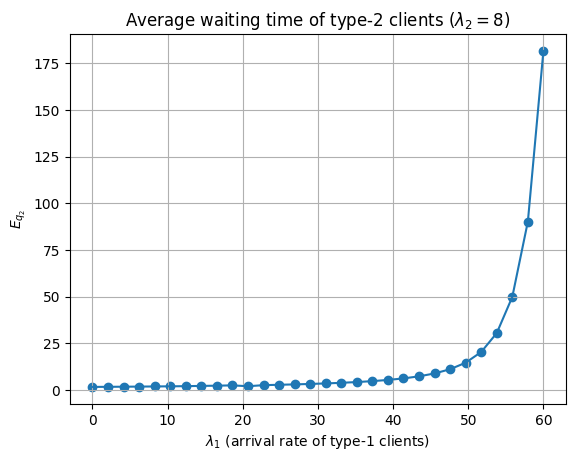

In [11]:
# Plot results
print(f'{S = },\n{mu_1 = },\n{mu_2 = },\n{lambda_2 = }')
plt.plot(lambdas_1, avg_times)
plt.scatter(lambdas_1, avg_times)
plt.title("Average waiting time of type-2 clients ($\\lambda_2 = 8$)")
plt.xlabel("$\\lambda_1$ (arrival rate of type-1 clients)")
plt.ylabel("$E_{q_2}$")
plt.grid(True)
plt.show()

## 6. Canaux de garde

Comme il est difficile d'implémenter la politique préemptive, on se contente souvent d'un système de canaux de garde. Les arrivées de classe 1 occupent un serveur tant qu'il y en a un de libre et ne peuvent être mis dans la salle d'attente. En d'autres termes, si tous les serveurs sont pris, éventuellement en partie par des clients de classe 2, les clients de classe 1 qui arrivent sont perdus.

Les clients de classe 2 ne peuvent entrer dans les serveurs que s'il y a au moins $ G $ serveurs libres (avec $ G $ à déterminer mais généralement très petit devant $ S $). Cette règle s'applique à leur arrivée ou au moment où un serveur se libère.

### Partie 5

1. **Pourquoi est-ce que le processus $ (Q_1, Q_2) $ défini précédemment n'est plus un processus de Markov représentant ce système ?**

> &nbsp;
>
> Dans le système ci-dessus, les clients de classe 2 ne peuvent être servis que s'il y a $G$ serveurs libres, ce qui signifie que les transitions d'état dépendent d'une condition passée sur les serveurs, pas seulement sur $(Q_1, Q_2)$. Par exemple, s'il y a $Q_1$ clients de classe 1 en train d'être servis, la quantité de serveurs disponibles pour servir les clients de classe 2 est dynamique et ne peut pas être déduite uniquement à partir de $(Q_1, Q_2)$ - ce qui ne suit pas les propriétés du processus markovien.
>
> &nbsp;

2. **Représenter la dynamique de ce système par un processus de Markov dont on précisera le générateur infinitésimal.**

> &nbsp;
>
> Nous devons inclure des informations supplémentaires sur l'état des serveurs, donc nous pouvons définir de nouveaux états $X_1, X_2$, $B$ où :
> - $X_1$ est le nombre de clients de type 1 en train d'être servis 
> - $X_2$ est le nombre de clients de type 2 en train d'être servis   
> - $B$ est le nombre de clients de type 2 dans le buffer  
> Les transitions possibles sont :
> - $X_1 \rightarrow X_1+1$  
> Un client de type 1 arrive avec le taux $\lambda_1$ s'il y a des serveurs disponibles ($X_1+X_2 < S$)
> - $X_1 \rightarrow X_1-1$  
> Un client de type 1 part avec le taux $X_1\mu_1$ sans condition
> - $X_2 \rightarrow X_2+1$  
> Un client de type 2 est servi immédiatement - avec le taux $\lambda_2$- si le buffer est vide ($B = 0$)
> - $X_2 \rightarrow X_2-1$  
> Un client de type 2 part avec le taux $X_2\mu_2$ si le buffer est vide. Sinon, il serait simplement "remplacé" par un autre client de type 2 du buffer.
> - $B \rightarrow B+1$  
> Un client de type 2 arrive s'il n'y a pas $G$ serveurs disponibles ($S - (X_1+X_2) < G$)  
> - $B \rightarrow B-1$  
> Un client de type 2 est servi depuis le buffer s'il y a au moins $G$ serveurs disponibles $(S - (X_1+X_2) \geq G) \text{ et } B > 0$
>
> &nbsp;

3. **Sans faire de calculs, est-ce que la condition de stabilité est plus ou moins contraignante sur $ \rho_2 $ que dans le premier modèle ?**

> &nbsp;
>
> La condition de stabilité est plus restrictive sur $ \rho_2 $ pour le modèle à canaux de garde que pour le modèle préemptif. Dans le système à priorité préemptive, les clients de classe 1 peuvent toujours préempter un serveur même si tous les serveurs sont déjà occupés à servir des clients de classe 2. Ainsi, les clients de classe 1 ne sont jamais retardés, et les clients de classe 2 peuvent être servis par n'importe quel serveur qui n'est pas occupé à ce moment-là par des clients de classe 1. Il n'y a pas de réservation à long terme de serveurs pour les clients de classe 1 ; le système alloue les serveurs dynamiquement en fonction de la demande et de la priorité. Ainsi, les clients de classe 2 ont accès à la capacité totale des serveurs lorsque la demande de classe 1 est faible, et la seule restriction sur $ \rho_2 $ vient de l'utilisation moyenne globale des ressources du système. 
>
> En comparaison, le modèle à canaux de garde a une contrainte stricte : les clients de classe 2 ne peuvent utiliser les serveurs que lorsqu'au moins $ G $ serveurs sont libres, ce qui signifie qu'une partie des serveurs est effectivement réservée en permanence pour les arrivées potentielles de clients de classe 1. Les clients de classe 2 ne peuvent pas utiliser ces serveurs même si les clients de classe 1 ne sont pas présents. Ainsi, le nombre maximum de serveurs pouvant être utilisés par les clients de classe 2 est réduit de manière permanente à $ S - G $, ce qui diminue leur capacité de service effective. Donc, pour être stable et ne pas avoir une surcharge de clients de classe 2, le taux d'arrivée $ \lambda_2 $ par rapport au taux de service $ \mu_2 $ doit être plus faible que dans le modèle préemptif. Cela rend la condition de stabilité dans le modèle à canaux de garde plus contraignante sur $ \rho_2 $, puisque les clients de classe 2 sont soumis à une politique d'accès plus limitative qui ne leur permet pas d'utiliser certaines des ressources même si elles sont disponibles.
> 
> En résumé, comme les clients de classe 2 ont moins accès aux serveurs dans le modèle à canaux de garde en raison de la politique de réservation, le système peut supporter une charge plus faible de clients de classe 2. Ainsi, la condition de stabilité sur $ \rho_2 $ est plus restrictive que dans le modèle préemptif.
>
> &nbsp;